## Introduction
This notebook presents an Exploratory Data Analysis (EDA) for AlphaCare Insurance Solutions (ACIS), a company focused on optimizing car insurance planning and marketing in South Africa. Leveraging historical insurance claim data, the analysis aims to uncover low-risk customer segments and inform marketing strategies to attract new clients through premium adjustments. The EDA includes data cleaning, statistical summaries, group-based risk assessments, and visualizations to identify trends and correlations. This work supports ACIS’s business objective of developing cutting-edge risk and predictive analytics, providing actionable insights for tailoring insurance products to consumer needs.

---

### 1. Setup Python Path

**Description**: This section sets up the Python environment by adding the parent directory to the system path. This allows the notebook to import custom modules from the `scripts` directory, ensuring access to data loading, EDA, and visualization functions.

In [ ]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

### 2. Import Functions

**Description**: Imports all necessary functions from custom scripts for data processing, analysis, and visualization. This modular approach separates concerns and promotes code reusability.

In [ ]:
from scripts.data_loader import convert_txt_to_csv, load_data
from scripts.eda import (
    summarize_data, 
    check_missing_values,
    clean_insurance_data, 
    calculate_loss_ratio, 
    loss_ratio_by_group, 
    claims_by_make_model
)
from scripts.visualizations import (
    plot_claim_distribution, 
    plot_premium_distribution, 
    plot_outliers_custom_value, 
    plot_loss_ratio_by_province, 
    plot_claim_trend_over_time,
    plot_correlation_heatmap, 
    plot_scatter_premium_claims_by_zip
)

### 3. Convert Raw Data

**Description**: Converts the raw pipe-delimited text file into a CSV format for easier handling with pandas. This step prepares the data for subsequent analysis.

In [ ]:
convert_txt_to_csv("../data/raw/MachineLearningRating_v3.txt", "../data/processed/MachineLearningRating_v3.csv")

### 4. Load Data

**Description**: Loads the CSV data into a pandas DataFrame and cleans it by converting date fields, dropping columns with over 90% missing values, removing rows with negative premiums or claims, and handling loss ratio calculations. Missing value analysis is reported.

**Insights**: 
- Dropping `CrossBorder` and `NumberOfVehiclesInFleet` due to high missingness is reasonable, as these features likely lack sufficient data for meaningful analysis.
- Significant missingness in `CustomValueEstimate` (779,361) and `WrittenOff`, `Rebuilt`, `Converted` (641,638 each) suggests these fields may not be reliable for modeling unless imputed or excluded. Gender and MaritalStatus have moderate missingness (9,536 and 8,259), which could be addressed with imputation for demographic analysis.

In [ ]:
df = load_data("../data/processed/MachineLearningRating_v3.csv")

c:\Users\User\Documents\Python\car-insurance-risk-modeling\scripts\data_loader.py:19: DtypeWarning: Columns (32,37) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(csv_path)


In [5]:
df_cleaned = clean_insurance_data(df)

Columns dropped due to missingness > 90%:
 ['CrossBorder', 'NumberOfVehiclesInFleet']

Remaining missing value counts:
 Bank                   145961
AccountType             40232
MaritalStatus            8259
Gender                   9536
mmcode                    550
VehicleType               550
make                      550
Model                     550
Cylinders                 550
cubiccapacity             550
kilowatts                 550
bodytype                  550
NumberOfDoors             550
VehicleIntroDate          550
CustomValueEstimate    779361
CapitalOutstanding          2
NewVehicle             153050
WrittenOff             641638
Rebuilt                641638
Converted              641638
dtype: int64


### 5. Summarize Data

**Description**: Provides a statistical summary (info and describe) and checks for remaining missing values post-cleaning.

**Insights**: 
- The high maximum values for `TotalClaims` and `LossRatio` suggest the presence of outliers, which could skew risk assessments. Further investigation via visualizations is warranted.
- The dataset spans from October 2013 to August 2015, offering a reasonable timeframe for trend analysis.

In [ ]:
summarize_data(df_cleaned)
print("\nMissing Values:\n", check_missing_values(df_cleaned))

Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 999805 entries, 0 to 1000097
Data columns (total 51 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   UnderwrittenCoverID       999805 non-null  int64         
 1   PolicyID                  999805 non-null  int64         
 2   TransactionMonth          999805 non-null  datetime64[ns]
 3   IsVATRegistered           999805 non-null  bool          
 4   Citizenship               999805 non-null  object        
 5   LegalType                 999805 non-null  object        
 6   Title                     999805 non-null  object        
 7   Language                  999805 non-null  object        
 8   Bank                      853844 non-null  object        
 9   AccountType               959573 non-null  object        
 10  MaritalStatus             991546 non-null  object        
 11  Gender                    990269 non-null  object        


**Output**:
- **Data Info**:  
  `<class 'pandas.core.frame.DataFrame'>  
  Index: 999805 entries, 0 to 1000097  
  Data columns (total 51 columns): ...`  
- **Descriptive Stats**:  
  - `TotalClaims`: Mean 64.90, Max 393,092.11, indicating a skewed distribution with outliers.
  - `TotalPremium`: Mean 61.95, Max 65,282.60, also skewed.
  - `LossRatio`: Mean 0.216, Max 2,553.6, showing extreme variability.
  - `CustomValueEstimate`: Mean 225,530.70, Max 26,550,000, with significant outliers.

### 6. Add Loss Ratio

**Description**: Adds a `LossRatio` column (TotalClaims / TotalPremium) to the DataFrame, with a safeguard for zero-premium cases.

**Insight**: This metric is crucial for assessing risk profitability, aligning with the objective to identify low-risk segments.

In [ ]:
df = calculate_loss_ratio(df_cleaned)

### 7. Group Analysis

**Description**: Aggregates loss ratios by Province, Gender, and VehicleType, and identifies top/bottom vehicle makes/models by total claims.

**Insights**: 
- Provinces like Gauteng and KwaZulu-Natal have higher loss ratios, suggesting higher risk, while Northern Cape is a low-risk candidate for premium reduction.
- Gender differences are minimal, with "Not specified" skewing results; further imputation may clarify male/female risk.
- Heavy Commercial vehicles pose the highest risk, while Buses are the lowest, guiding targeted marketing.
- Toyota models with high claims may indicate maintenance or usage issues, while BMW/VW models with zero claims could be low-risk targets.

In [ ]:
province_stats = loss_ratio_by_group(df_cleaned, 'Province')
gender_stats = loss_ratio_by_group(df_cleaned, 'Gender')
print("\nLoss Ratio by Province:\n", province_stats)
print("\nLoss Ratio by Gender:\n", gender_stats)

# By Vehicle Type
vehicle_type_stats = loss_ratio_by_group(df_cleaned, 'VehicleType')
print(vehicle_type_stats)

# By Make/Model
top_makes, bottom_makes = claims_by_make_model(df_cleaned)
print("Top Claiming Vehicles:\n", top_makes)
print("Lowest Claiming Vehicles:\n", bottom_makes)


Loss Ratio by Province:
                 TotalClaims  TotalPremium  LossRatio
Province                                            
Gauteng        2.940641e+07  2.405423e+07   1.222505
KwaZulu-Natal  1.430138e+07  1.323578e+07   1.080509
Western Cape   1.039546e+07  9.809536e+06   1.059730
North West     5.920250e+06  7.490508e+06   0.790367
Mpumalanga     2.045383e+06  2.836292e+06   0.721147
Free State     3.549223e+05  5.213632e+05   0.680758
Limpopo        1.016477e+06  1.537324e+06   0.661199
Eastern Cape   1.356427e+06  2.140303e+06   0.633755
Northern Cape  8.949051e+04  3.165581e+05   0.282699

Loss Ratio by Gender:
                 TotalClaims  TotalPremium  LossRatio
Gender                                              
Not specified  6.273276e+07  5.920661e+07   1.059557
Male           1.396704e+06  1.606618e+06   0.869344
Female         2.502461e+05  3.044806e+05   0.821879
                    TotalClaims  TotalPremium  LossRatio
VehicleType                                  

**Output**:
- **Loss Ratio by Province**:  
  - Highest: Gauteng (1.222), Lowest: Northern Cape (0.282).
- **Loss Ratio by Gender**:  
  - Highest: Not specified (1.060), Lowest: Female (0.822).
- **Loss Ratio by VehicleType**:  
  - Highest: Heavy Commercial (1.628), Lowest: Bus (0.137).
- **Top Claiming Vehicles**: Toyota models (e.g., QUANTUM 2.7 SESFIKILE 16s) dominate high claims.
- **Lowest Claiming Vehicles**: BMW and Volkswagen models show zero claims.

**Description**: Aggregates loss ratios by Province, Gender, and VehicleType, and identifies top/bottom vehicle makes/models by total claims.

### 8. Visualizations

**Description**: Generates various plots to visualize distributions, trends, and relationships in the data.

**Insights**: 
- Skewed distributions highlight the need for outlier handling in modeling.
- Temporal trends suggest seasonal marketing adjustments.
- Weak correlations indicate that advanced modeling (e.g., machine learning) is needed to capture complex risk patterns.

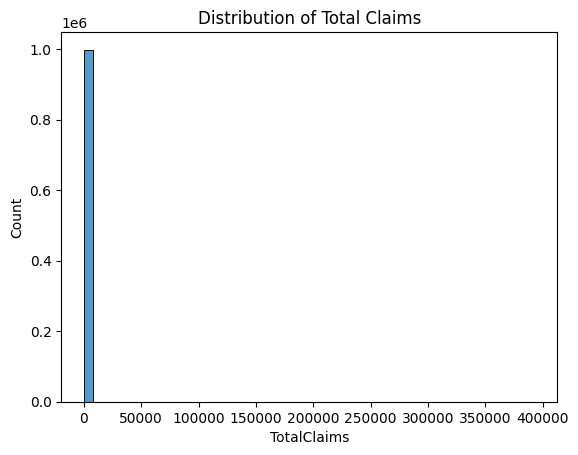

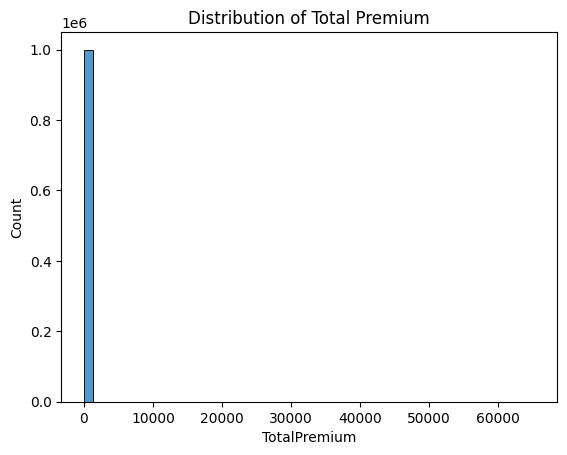

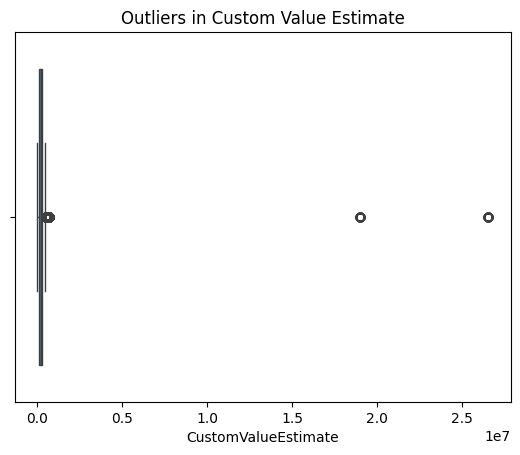

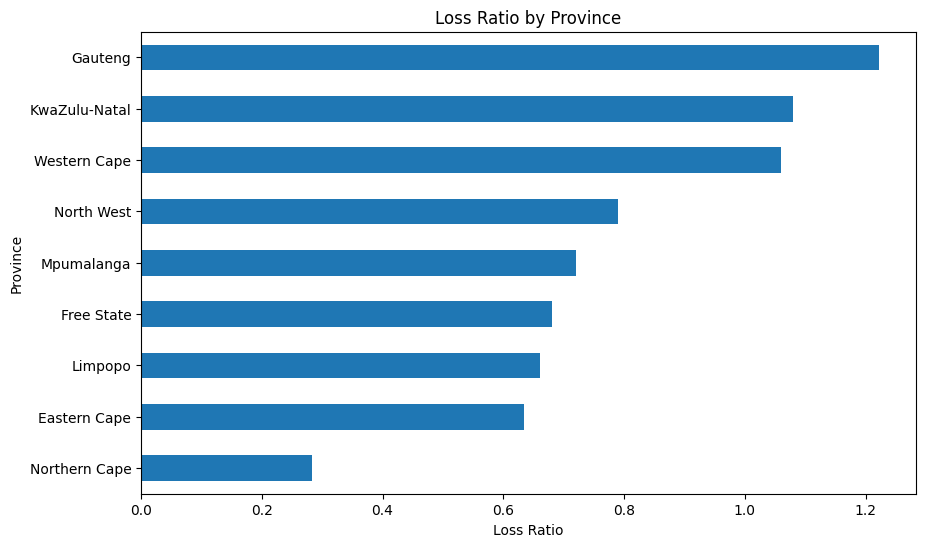

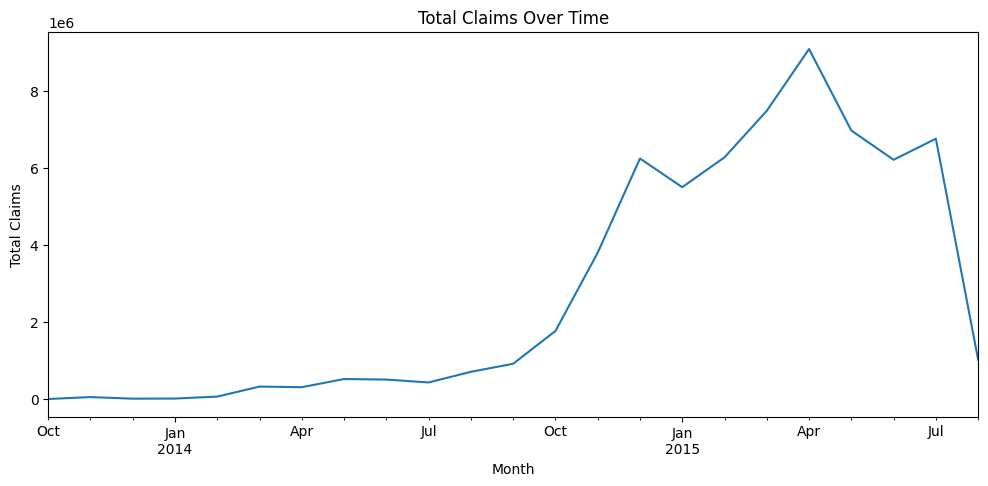

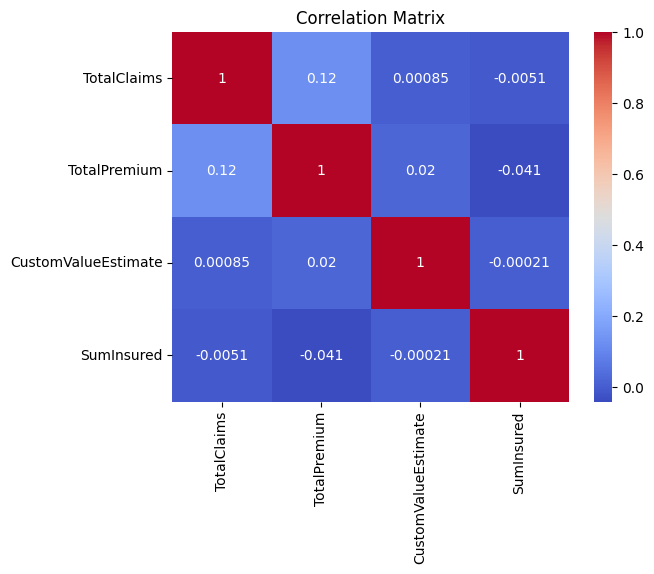

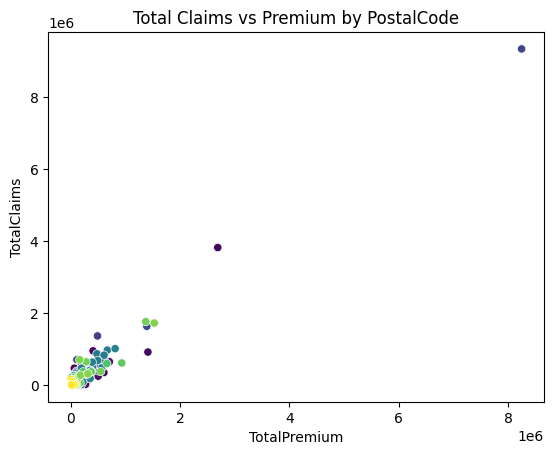

In [ ]:
plot_claim_distribution(df_cleaned)
plot_premium_distribution(df_cleaned)
plot_outliers_custom_value(df_cleaned)
plot_loss_ratio_by_province(df_cleaned)
plot_claim_trend_over_time(df_cleaned)
plot_correlation_heatmap(df_cleaned)
plot_scatter_premium_claims_by_zip(df_cleaned)

**Output Descriptions and Insights**:
- **Distribution of Total Claims**: Shows a right-skewed distribution with most claims near zero, and a long tail of high claims, indicating outliers.
- **Distribution of Total Premium**: Similarly skewed, with most premiums low, suggesting a concentration of low-cost policies.
- **Outliers in Custom Value Estimate**: Boxplot reveals extreme outliers, indicating potential data entry errors or high-value vehicles needing separate analysis.
- **Loss Ratio by Province**: Bar chart confirms Northern Cape as the lowest risk, supporting targeted marketing there.
- **Total Claims Over Time**: Line chart shows a peak in early 2015, possibly due to seasonal factors or external events, followed by a decline.
- **Correlation Matrix**: Weak correlations (e.g., TotalClaims and TotalPremium: 0.12) suggest multidimensional risk factors.
- **Total Claims vs Premium by PostalCode**: Scatter plot shows clustering at low claims/premiums, with some high-claim outliers, useful for zipcode risk segmentation.

### 9. Save Cleaned Data

**Description**: Saves the cleaned dataset for use in subsequent modeling steps.

**Insight**: This ensures data consistency across the project pipeline.

In [11]:
# Save cleaned data
df_cleaned.to_csv("../data/processed/MachineLearningRating_v3_cleaned.csv", index=False)

---

### Recommendations

- **Low-Risk Segments**: Target Northern Cape and provinces with low loss ratios (e.g., Eastern Cape) for premium reductions to attract new clients.
- **Vehicle Targeting**: Promote insurance for low-claim vehicles (e.g., BMW, Bus) and investigate high-claim Toyota models for risk mitigation.
- **Modeling**: Use linear regression for zipcode-specific claims prediction and a machine learning model with features like vehicle type, owner demographics, and location to optimize premiums.
- **A/B Testing**: Test null hypotheses on province, zipcode, gender, and margin differences to validate risk segmentation.